# Predicting the Football World Cup


# Data I/O
Three datasets were used:

1. FIFA rankings from 1993 to 2018 - used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a decent predictor of team performance

2. International Soccer matches from 1872 to 2018  to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match

3. FIFA World Cup 2018 data set to get the upcoming matches

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/djmaan/Data-Science-Project/master/football_prediction/fifa_ranking.csv")
rankings = rankings.loc[:,['rank','country_full','country_abrv','cur_year_avg_weighted','rank_date','two_year_ago_weighted','three_year_ago_weighted']]

rankings = rankings.replace({"IR Iran":"Iran"})

# Get weighted points by summimg cur_year_avg_weighted + two_year_ago_weighted + three_year_weighted
rankings['weighted_points'] = rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

# Get the match date
matches = pd.read_csv("https://raw.githubusercontent.com/djmaan/Data-Science-Project/master/football_prediction/results.csv")

matches = matches.replace({'Germany DR' : 'Germany', 'China' : 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the World Cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/djmaan/Data-Science-Project/master/football_prediction/WorldCup2018Dataset.csv")

world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')

world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})

world_cup = world_cup.set_index('Team')

In [2]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [3]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
world_cup.head()

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran


# Feature Extraction

In [5]:
# we join the matches with ranks of the different teams.

rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys = False)\
            .resample('D').first()\
            .fillna(method = 'ffill')\
            .reset_index()

rankings.head()

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,2003-01-15,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
1,2003-01-16,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
2,2003-01-17,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
3,2003-01-18,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0
4,2003-01-19,204.0,Afghanistan,AFG,0.0,0.0,0.0,0.0


In [6]:
# Adding Fifa Rankings to Match Data
# join the ranks
# First we do it for the Home Teams

matches  = matches.merge(rankings, 
                         left_on = ['date','home_team'],
                         right_on = ['rank_date','country_full'])
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0


In [7]:
# Next we do it for the Away Teams
matches = matches.merge(rankings,
                        left_on = ['date','away_team'],
                        right_on = ['rank_date','country_full'],
                        suffixes = ('_home','_away'))
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0


In [8]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0
matches['is_stake'] = matches['tournament'] != 'Friendly'

matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,country_abrv_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,weighted_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,cur_year_avg_weighted_away,two_year_ago_weighted_away,three_year_ago_weighted_away,weighted_points_away,rank_difference,average_rank,point_difference,score_difference,is_won,is_stake
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,BOL,0.0,0.0,0.0,0.0,1993-08-08,22.0,Uruguay,URU,0.0,0.0,0.0,0.0,37.0,40.5,0.0,2,True,True
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,BRA,0.0,0.0,0.0,0.0,1993-08-08,14.0,Mexico,MEX,0.0,0.0,0.0,0.0,-6.0,11.0,0.0,0,False,False
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,ECU,0.0,0.0,0.0,0.0,1993-08-08,94.0,Venezuela,VEN,0.0,0.0,0.0,0.0,-59.0,64.5,0.0,5,True,True
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,GUI,0.0,0.0,0.0,0.0,1993-08-08,86.0,Sierra Leone,SLE,0.0,0.0,0.0,0.0,-21.0,75.5,0.0,1,True,False
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,PAR,0.0,0.0,0.0,0.0,1993-08-08,5.0,Argentina,ARG,0.0,0.0,0.0,0.0,62.0,36.0,0.0,-2,False,True


# Modeling

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       False       0.69      0.68      0.69      1908
        True       0.67      0.68      0.67      1788

    accuracy                           0.68      3696
   macro avg       0.68      0.68      0.68      3696
weighted avg       0.68      0.68      0.68      3696



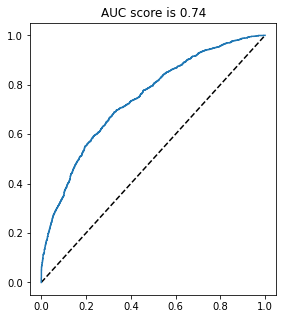

In [9]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# We look at only 4 features
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Use a logistic Regression model
logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Plot our model results 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

Stakes distribution in the wrong predictions
True     0.575169
False    0.424831
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


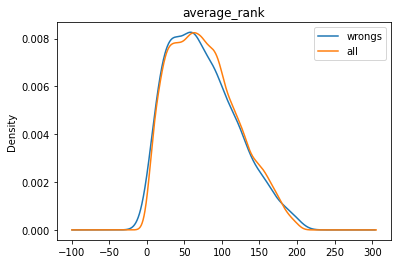

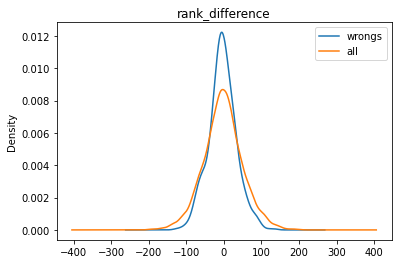

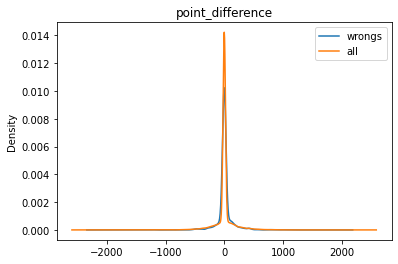

In [10]:
features = ['average_rank', 'rank_difference', 'point_difference']

# Get the wrongly predicted matches
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these Figure
- we predict worse for closer ranks
- lower ranks in general

# World Cup Simulation

In [11]:
margin = 0.025 

world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings.head()                            

,rank_date,rank,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
country_full,,,,,,,
Argentina,2018-06-07,5.0,ARG,404.07,248.99,183.59,836.65
Australia,2018-06-07,36.0,AUS,366.60,98.16,59.79,524.55
Belgium,2018-06-07,3.0,BEL,629.98,158.94,186.58,975.50
Brazil,2018-06-07,2.0,BRA,558.95,168.06,162.38,889.39
Colombia,2018-06-07,16.0,COL,292.09,199.73,166.38,658.20


In [12]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # get the prediction proability of the home team winning
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group B:___
Portugal vs. Spain: Portugal wins with 0.54
Portugal vs. Morocco: Portugal wins with 0.66
Portugal vs. Iran: Portugal wins with 0.65
Spain vs. Morocco: Spain wins with 0.64
Spain vs. Iran: Spain wins with 0.62
Morocco vs. Iran: Iran wins with 0.54
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.60
Argentina vs. Croatia: Argentina wins with 0.59
Argentina vs. Nigeria: Argentina wins with 0.67
Iceland vs. Croatia: Draw
Iceland vs. Nigeria: Iceland wins with 0.60
Croatia vs. Nigeria: Croatia wins with 0.61
___Starting group C:___
France vs. Australia: France wins with 0.63
France vs. Peru: Draw
France vs. Denmark: Draw
Australia vs. Peru: Peru wins with 0.66
Australia vs. Denmark: Denmark wins with 0.70
Peru vs. Denmark: Denmark wins with 0.55
___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.69
Belgium vs. Tunisia: Belgium wins with 0.61
Belgium vs. England: Belgium wins with 0.57
Panama vs. Tunisia: Tunisia wins with 0.70
Panama

In [13]:
world_cup

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay,0,1.013338
Saudi Arabia,A,Russia,Uruguay,Egypt,3,1.124677
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.538740
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.323245
Portugal,B,Spain,Morocco,Iran,9,1.854178
Spain,B,Portugal,Iran,Morocco,6,1.714135
Morocco,B,Iran,Portugal,Spain,0,1.165354
Iran,B,Morocco,Spain,Portugal,3,1.266334
France,C,Australia,Peru,Denmark,5,1.632908


In [14]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.323245
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.538740
Spain,B,Portugal,Iran,Morocco,6,1.714135
Portugal,B,Spain,Morocco,Iran,9,1.854178
Denmark,C,Peru,Australia,France,7,1.766835
France,C,Australia,Peru,Denmark,5,1.632908
Croatia,D,Nigeria,Argentina,Iceland,4,1.541201
Argentina,D,Iceland,Croatia,Nigeria,9,1.859186
Brazil,E,Switzerland,Costa Rica,Serbia,9,1.806766


In [ ]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = model.predict_proba(row)[:,1][0]
        
        # Display resultes
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")